## Source detection maps

\begin{equation}
    {\color{red}{
    r_1(\Omega, F_{th}; \boldsymbol{x})}
    \equiv \frac{
    p(\mathbb{I}(F \geq F_{th})=1, \Omega|\boldsymbol{x})
    }{
    p(\mathbb{I}(F \geq F_{th})=1, \Omega)
    }
    }\;.
\end{equation}

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import torch
import swyft
import swyft.lightning as sl
import sims
from networks import NetworkMaps
import skimage

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

### Simulate

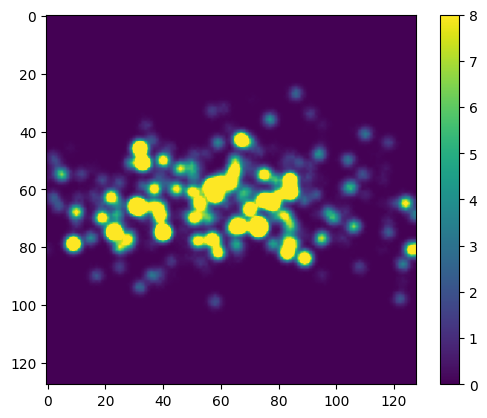

In [3]:
simulator = sims.ToyFermi(npix = 128)
plt.imshow(simulator.sample()['data'], vmax = 8)
plt.colorbar();

In [4]:
shapes, dtypes = simulator.get_shapes_and_dtypes()
zs = swyft.ZarrStore("/project/fermi_data/neurips_original.zarr").init(50000, 64, shapes, dtypes)
zs.simulate(simulator, batch_size = 500)

### Train for sensitivity maps

Resample noise and PSF

In [5]:
from scipy.ndimage import gaussian_filter

def hook(out):
    out['mu'] =  gaussian_filter(out['mu_psc'], 1.5)*4   # resample psf
    out['data'] = np.random.poisson(out['mu']*100)/100  # resample noise
    out = sl.to_numpy32(out)
    return out


dl_train = zs.get_dataloader(idx_range = [0, 36000], batch_size = 32, num_workers = 8, on_after_load_sample = hook)
dl_val = zs.get_dataloader(idx_range = [36000, 40000], batch_size = 32, num_workers = 8, on_after_load_sample = hook)

Train

In [6]:
logger = TensorBoardLogger("./lightning_logs", name = 'neurips_detection', version='version_0')
checkpoint_callback = ModelCheckpoint(monitor="val_loss", filename="{epoch:02d}-{val_loss:.2f}", save_top_k=1, mode="min",)

trainer = swyft.SwyftTrainer(
    accelerator = 'gpu', 
    gpus=1, 
    max_epochs = 100, 
    logger = logger, 
    callbacks = [checkpoint_callback]
)
network_maps = NetworkMaps(lr=1e-3, lrs_factor = 0.1, lrs_patience = 3, early_stopping_patience = 5)

/home/noemiam/.pyenv/versions/3.10.0/envs/fermi-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/noemiam/.pyenv/versions/3.10.0/envs/fermi-3.10.0/lib/python3.10/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
# trainer.fit(network_maps, train_dataloaders = dl_train, val_dataloaders = dl_val)

In [8]:
# checkpoint_callback.to_yaml(checkpoint_callback.dirpath+"/model.yaml")
# ckpt_path = swyft.best_from_yaml(checkpoint_callback.dirpath+"/model.yaml")
ckpt_path = swyft.best_from_yaml("./lightning_logs/neurips_detection/version_0/checkpoints"+"/model.yaml")

print(ckpt_path)
trainer.test(network_maps, dl_val, ckpt_path = ckpt_path)

Restoring states from the checkpoint path at ./lightning_logs/neurips_detection/version_0/checkpoints/epoch=34-val_loss=-1090.87.ckpt


./lightning_logs/neurips_detection/version_0/checkpoints/epoch=34-val_loss=-1090.87.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ./lightning_logs/neurips_detection/version_0/checkpoints/epoch=34-val_loss=-1090.87.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            -1086.26904296875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': -1086.26904296875}]

### Inference 

[147.59367     1.5220364  16.407606 ]


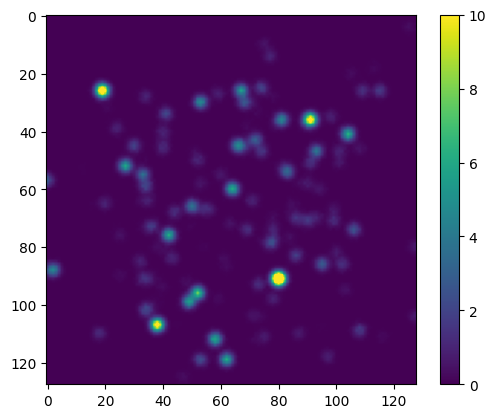

In [9]:
s0 = zs[-1]
np.save('obs.npy', s0)

plt.imshow(s0['data'], vmax=10)
plt.colorbar();
print(s0['pdp'])

Point source exclusion maps

In [10]:
out = trainer.infer(network_maps, swyft.Sample(s0), swyft.Sample(s0), return_sample_ratios = False)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, LearningRateMonitor
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/home/noemiam/.pyenv/versions/3.10.0/envs/fermi-3.10.0/lib/python3.10/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:174: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


The network outputs:

\begin{equation}
    r_1(\Omega, F_{th}; \boldsymbol{x})  = \frac{
    p(\mathbb{I}(F \geq F_{th})=1, \Omega|\boldsymbol{x})
    }{
    p(\mathbb{I}(F \geq F_{th})=1, \Omega)
    }\;.
\end{equation}

In [11]:
maps = out[0]['aux_psc'][0,:,:].detach().clone()

Detection maps

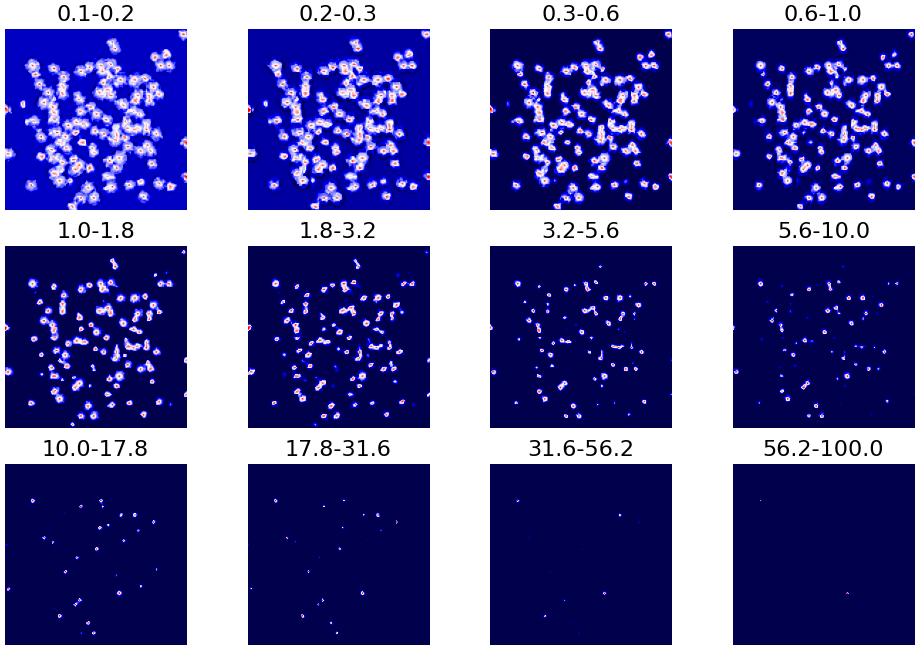

In [12]:
flux_threshold = np.logspace(-1, 2, 13) # flux bins
plt.style.use(['science', 'notebook'])
plt.figure(figsize=(12, 8))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    im = ax.imshow(maps[..., i] , cmap = 'seismic', vmin = -10, vmax = 10)
    plt.axis('off')
    ax.set_title("{:.1f}".format(flux_threshold[i])+'-'+"{:.1f}".format(flux_threshold[i+1]))
#     plt.colorbar(im, ax=ax)

We take $r_1(\Omega, F_{th}; \boldsymbol{x})>5$

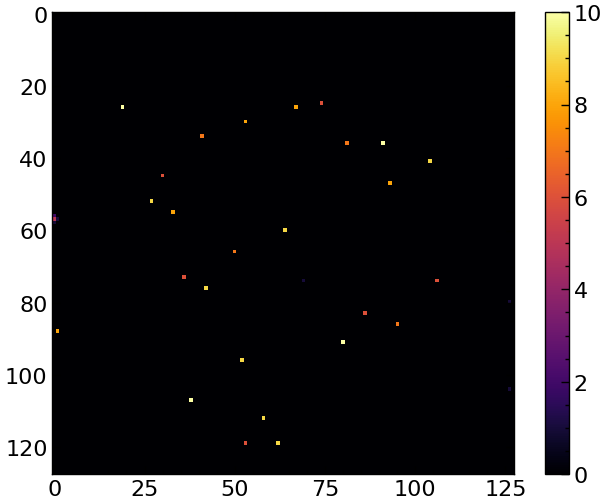

In [13]:
# Select detected sources based on flux threshold

cube = maps[...] > 5
n = cube.shape[-1]
m = np.zeros((128, 128))
for i in range(n):
    m[cube[:,:,i]] = i
    
plt.imshow(m, cmap='inferno', vmin=0, vmax=10)
plt.colorbar();

(-0.5, 127.5, 127.5, -0.5)

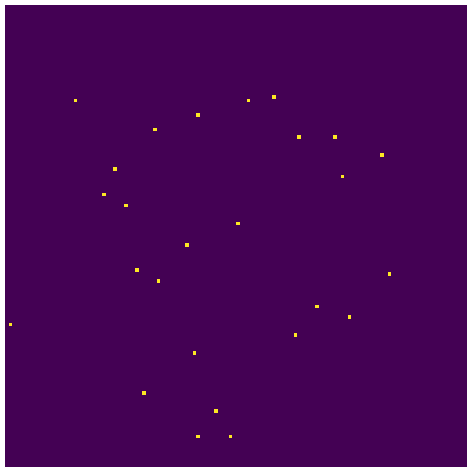

In [14]:
# Create labels for detected point sources by label connecting regions of the map
out2 = skimage.measure.label(m >= 6, connectivity=2)
plt.imshow(out2 > 0)
# plt.colorbar();
plt.axis('off')

In [15]:
X, Y = np.meshgrid(np.linspace(-40, 40, 128), np.linspace(-40, 40, 128))
psc_det = []
for i in range(1, out2.max()+1):
    xm = X[out2==i].mean()
    ym = Y[out2==i].mean()
    psc_det.append([ym, xm, 10.])
psc_det = torch.tensor(psc_det).float()

print(f'{len(psc_det)} point sources detected')

26 point sources detected


In [16]:
np.save('neurips_ps_det.npy', psc_det)